# Using PyMC3

PyMC3 is a Python package for doing MCMC using a variety of samplers, including Metropolis, Slice and Hamiltonian Monte Carlo. See [Probabilistic Programming in Python using PyMC](http://arxiv.org/abs/1507.08050) for a description. The GitHub [site](https://github.com/pymc-devs/pymc3) also has many examples and links for further exploration.

```bash
! pip install --quiet arviz
! pip install --quiet pymc3
! pip install --quiet daft
! pip install --quiet seaborn
```

```bash
! conda install --yes --quiet mkl-service
```

In [1]:
import warnings

warnings.simplefilter('ignore', UserWarning)

**Other resources**

Some examples are adapted from:

- [Probabilistic Programming & Bayesian Methods for Hackers](http://camdavidsonpilon.github.io/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/)
- [MCMC tutorial series](https://theclevermachine.wordpress.com/2012/11/19/a-gentle-introduction-to-markov-chain-monte-carlo-mcmc/)

In [2]:
%matplotlib inline

In [3]:
import numpy as np
import numpy.random as rng
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pymc3 as pm
import scipy.stats as stats
import daft
import arviz as az

/Users/cliburn/anaconda3/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/Users/cliburn/anaconda3/lib/python3.6/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [4]:
import theano
theano.config.warn.round=False

In [5]:
sns.set_context('notebook')
plt.style.use('seaborn-darkgrid')

## Introduction to PyMC3

### Distributions in pymc3

In [6]:
print('\n'.join([d for d in dir(pm.distributions) if d[0].isupper()]))

AR
AR1
Bernoulli
Beta
BetaBinomial
Binomial
Bound
Categorical
Cauchy
ChiSquared
Constant
ConstantDist
Continuous
DensityDist
Dirichlet
Discrete
DiscreteUniform
DiscreteWeibull
Distribution
ExGaussian
Exponential
Flat
GARCH11
Gamma
GaussianRandomWalk
Geometric
Gumbel
HalfCauchy
HalfFlat
HalfNormal
HalfStudentT
Interpolated
InverseGamma
KroneckerNormal
Kumaraswamy
LKJCholeskyCov
LKJCorr
Laplace
Logistic
LogitNormal
Lognormal
MatrixNormal
Mixture
Multinomial
MvGaussianRandomWalk
MvNormal
MvStudentT
MvStudentTRandomWalk
NegativeBinomial
NoDistribution
Normal
NormalMixture
OrderedLogistic
Pareto
Poisson
Rice
SkewNormal
StudentT
TensorType
Triangular
TruncatedNormal
Uniform
VonMises
Wald
Weibull
Wishart
WishartBartlett
ZeroInflatedBinomial
ZeroInflatedNegativeBinomial
ZeroInflatedPoisson


In [7]:
d = pm.Normal.dist(mu=0, sd=1)

In [8]:
d.dist()

Random samples

In [9]:
d.random(size=5)

array([-1.04374916,  0.82779499,  0.63210758, -1.25758947,  0.54865016])

Log probability

In [10]:
d.logp(0).eval()

array(-0.91893853)

#### Custom distributions

The pymc3 algorithms generally only work with the log probability of a distribution. Hence it is easy to define custom distributions to use in your models by providing a `logp` function.

In [11]:
def logp(x, μ=0, σ=1):
    """Normal distribtuion."""
    return -0.5*np.log(2*np.pi) - np.log(σ) - (x-μ)**2/(2*σ**2)

In [12]:
d = pm.DensityDist.dist(logp)

In [13]:
d.logp(0)

-0.9189385332046727

## Example: Estimating coin bias

We start with the simplest model - that of determining the bias of a coin from observed outcomes.

### Setting up the model    

In [14]:
n = 100
heads = 61

#### Analytical solution

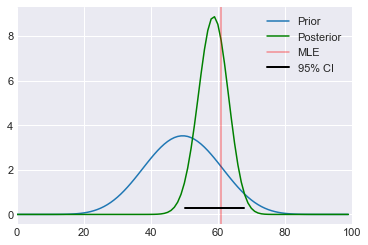

In [15]:
a, b = 10, 10
prior = stats.beta(a, b)
post = stats.beta(heads+a, n-heads+b)
ci = post.interval(0.95)

xs = np.linspace(0, 1, 100)
plt.plot(prior.pdf(xs), label='Prior')
plt.plot(post.pdf(xs), c='green', label='Posterior')
plt.axvline(100*heads/n, c='red', alpha=0.4, label='MLE')
plt.xlim([0, 100])
plt.axhline(0.3, ci[0], ci[1], c='black', linewidth=2, label='95% CI');
plt.legend()
pass

#### Graphical model

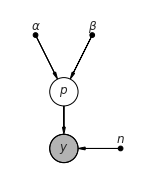

In [16]:
pgm = daft.PGM(shape=[2.5, 3.0], origin=[0, -0.5])

pgm.add_node(daft.Node("alpha", r"$\alpha$", 0.5, 2, fixed=True))
pgm.add_node(daft.Node("beta", r"$\beta$", 1.5, 2, fixed=True))
pgm.add_node(daft.Node("p", r"$p$", 1, 1))
pgm.add_node(daft.Node("n", r"$n$", 2, 0, fixed=True))
pgm.add_node(daft.Node("y", r"$y$", 1, 0, observed=True))

pgm.add_edge("alpha", "p")
pgm.add_edge("beta", "p")
pgm.add_edge("n", "y")
pgm.add_edge("p", "y")

pgm.render()
pass

### The Model context

When you specify a model, you are adding nodes to a computation graph. When executed, the graph is compiled via Theno. Hence, `pymc3` uses the Model context manager to automatically add new nodes.

In [17]:
niter = 2000
with pm.Model() as coin_context:
    p = pm.Beta('p', alpha=2, beta=2)
    y = pm.Binomial('y', n=n, p=p, observed=heads)
    trace = pm.sample(niter)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [p]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:03<00:00, 1456.13draws/s]


In [18]:
coin_context

#### Transformed prior variables

In [19]:
coin_context.free_RVs

[p_logodds__]

#### Prior variables

In [20]:
coin_context.deterministics

[p]

#### Variables in likelihood

In [21]:
coin_context.observed_RVs

[y]

### Under the hood

### Theano

Theano builds functions as mathematical expression graphs and compiles them into C for actual computation, making use of GPU resources where available.

Performing calculations in Theano generally follows the following 3 steps (from official docs):

- declare variables (a,b) and give their types
- build expressions for how to put those variables together
- compile expression graphs to functions in order to use them for computation.

In [22]:
import theano
import theano.tensor as tt
theano.config.compute_test_value = "off"

This part builds symbolic expressions.

In [23]:
a = tt.iscalar('a')
b = tt.iscalar('x')
c = a + b

This step compiles a function whose inputs are [a, b] and outputs are [c].

In [24]:
f = theano.function([a, b], [c])

In [25]:
f

In [26]:
f(3, 4)

[array(7, dtype=int32)]

Within a model context, 

- when you add an unbounded variable, it is defined as a Theano variable and added to the prior part of the log posterior function
- when you add a bounded variable, a transformed version is defined as a Theano variable and and added to the log posterior function
    - The inverse transformation is used to define the original variable - this is a deterministic variable
- when you add an observed variable bound to data, the data is added to the likelihood part of the log posterior

See [PyMC3 and Theano](https://docs.pymc.io/PyMC3_and_Theano.html) for details.

In [27]:
help(pm.sample)

Help on function sample in module pymc3.sampling:

sample(draws=500, step=None, init='auto', n_init=200000, start=None, trace=None, chain_idx=0, chains=None, cores=None, tune=500, nuts_kwargs=None, step_kwargs=None, progressbar=True, model=None, random_seed=None, live_plot=False, discard_tuned_samples=True, live_plot_kwargs=None, compute_convergence_checks=True, use_mmap=False, **kwargs)
    Draw samples from the posterior using the given step methods.
    
    Multiple step methods are supported via compound step methods.
    
    Parameters
    ----------
    draws : int
        The number of samples to draw. Defaults to 500. The number of tuned samples are discarded
        by default. See discard_tuned_samples.
    step : function or iterable of functions
        A step function or collection of functions. If there are variables without a step methods,
        step methods for those variables will be assigned automatically.
    init : str
        Initialization method to use for au

### Specifying sampler (step) and multiple chains

In [28]:
with coin_context:
    step = pm.Metropolis()
    t = pm.sample(niter, step=step, chains=8, random_seed=123)

Multiprocess sampling (8 chains in 2 jobs)
Metropolis: [p]
Sampling 8 chains: 100%|██████████| 20000/20000 [00:05<00:00, 3712.51draws/s]
The number of effective samples is smaller than 25% for some parameters.


### Samplers available

For continuous distributions, it is hard to beat NUTS and hence this is the default. To learn more, see [A Conceptual Introduction to Hamiltonian Monte Carlo](https://arxiv.org/pdf/1701.02434.pdf).

In [29]:
print('\n'.join(m for m in dir(pm.step_methods) if m[0].isupper()))

BinaryGibbsMetropolis
BinaryMetropolis
CSG
CategoricalGibbsMetropolis
CauchyProposal
CompoundStep
DEMetropolis
ElemwiseCategorical
EllipticalSlice
HamiltonianMC
LaplaceProposal
Metropolis
MultivariateNormalProposal
NUTS
NormalProposal
PoissonProposal
SGFS
SMC
Slice


Generally, the sampler will be automatically selected based on the type of the variable (discrete or continuous), but there are many samples that you can explicitly specify if you want to learn more about them or understand why an alternative would be better than the default for your problem.

In [30]:
niter = 2000
with pm.Model() as normal_context:
    mu = pm.Normal('mu', mu=0, sd=100)
    sd = pm.HalfCauchy('sd', beta=2)
    y = pm.Normal('y', mu=mu, sd=sd, observed=xs)
    
    step1 = pm.Slice(vars=mu)
    step2 = pm.Metropolis(vars=sd)
    
    t = pm.sample(niter, step=[step1, step2])

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Slice: [mu]
>Metropolis: [sd]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:02<00:00, 1691.48draws/s]
The number of effective samples is smaller than 10% for some parameters.


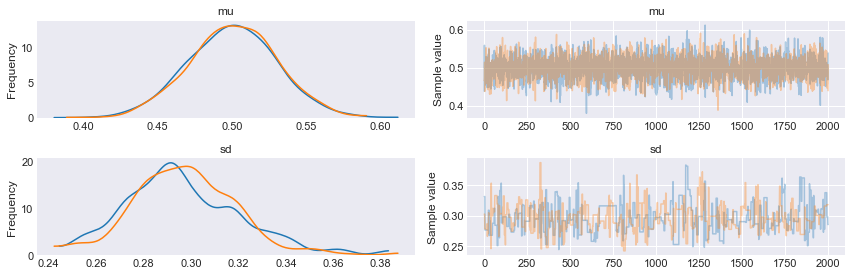

In [32]:
pm.traceplot(t)
pass

#### MAP estimate

In [33]:
with pm.Model() as m:
    p = pm.Beta('p', alpha=2, beta=2)
    y = pm.Binomial('y', n=n, p=p, observed=heads)
    θ = pm.find_MAP()

/Users/cliburn/anaconda3/lib/python3.6/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -4.5407, ||grad|| = 11: 100%|██████████| 6/6 [00:00<00:00, 563.70it/s]


In [34]:
θ

{'p_logodds__': array(0.43825493), 'p': array(0.60784314)}

#### Getting values from the trace

All the information about the posterior is in the trace, and it also provides statistics about the sampler.

In [35]:
help(trace)

Help on MultiTrace in module pymc3.backends.base object:

class MultiTrace(builtins.object)
 |  Main interface for accessing values from MCMC results
 |  
 |  The core method to select values is `get_values`. The method
 |  to select sampler statistics is `get_sampler_stats`. Both kinds of
 |  values can also be accessed by indexing the MultiTrace object.
 |  Indexing can behave in four ways:
 |  
 |  1. Indexing with a variable or variable name (str) returns all
 |     values for that variable, combining values for all chains.
 |  
 |     >>> trace[varname]
 |  
 |     Slicing after the variable name can be used to burn and thin
 |     the samples.
 |  
 |     >>> trace[varname, 1000:]
 |  
 |     For convenience during interactive use, values can also be
 |     accessed using the variable as an attribute.
 |  
 |     >>> trace.varname
 |  
 |  2. Indexing with an integer returns a dictionary with values for
 |     each variable at the given index (corresponding to a single
 |     sam

In [36]:
trace.stat_names

{'depth',
 'diverging',
 'energy',
 'energy_error',
 'max_energy_error',
 'mean_tree_accept',
 'model_logp',
 'step_size',
 'step_size_bar',
 'tree_size',
 'tune'}

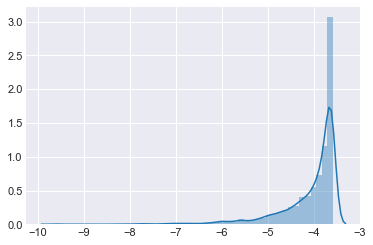

In [37]:
sns.distplot(trace.get_sampler_stats('model_logp'))
pass

In [38]:
p = trace.get_values('p')
p.shape

(4000,)

In [39]:
trace['p'].shape

(4000,)

#### Convert to `pandas` data frame for downstream processing

In [40]:
df = pm.trace_to_dataframe(trace)
df.head()

,p
0,0.597814
1,0.588101
2,0.576538
3,0.577302
4,0.550194


#### Posterior distribution

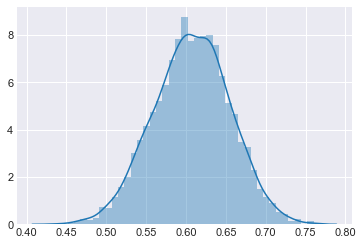

In [41]:
sns.distplot(trace['p'])
pass

#### Autocorrelation plot

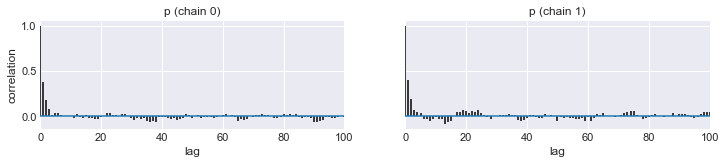

In [43]:
pm.autocorrplot(trace, varnames=['p'])
pass

#### Calculate effective sample size

$$
\hat{n}_{eff} = \frac{mn}{1 + 2 \sum_{t=1}^T \hat{\rho}_t}
$$

where $m$ is the number of chains, $n$ the number of steps per chain, $T$ the time when the autocorrelation first becomes negative, and $\hat{\rho}_t$ the autocorrelation at lag $t$.

In [44]:
pm.effective_n(trace)

{'p': 1639.0804767244163}

## Evaluate convergence

##### Gelman-Rubin

$$
\hat{R} = \frac{\hat{V}}{W}
$$

where $W$ is the within-chain variance and $\hat{V}$ is the posterior variance estimate for the pooled traces.  Values greater than one indicate that one or more chains have not yet converged.

Discrad burn-in steps for each chain. The idea is to see if the starting values of each chain come from the same distribution as the stationary state. 

- $W$ is the number of chains $m \times$ the variacne of each individual chain
- $B$ is the number of steps $n \times$ the variance of the chain means
- $\hat{V}$ is the weigthed average $(1 - \frac{1}{n})W + \frac{1}{n}B$

The idea is that $\hat{V}$ is an unbiased estimator of $W$ if the starting values of each chain come from the same distribution as the stationary state. Hence if $\hat{R}$ differs significantly from 1, there is probsbly no convergence and we need more iterations. This is done for each parameter $\theta$.

In [45]:
pm.gelman_rubin(trace)

{'p': 1.0011843767338002}

##### Geweke

Compares mean of initial with later segments of a trace for a parameter. Should have absolute value less than 1 at convergence.

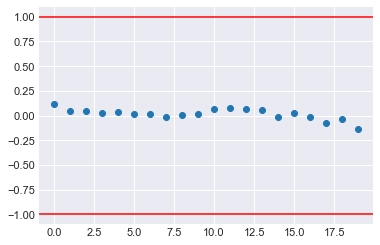

In [46]:
plt.plot(pm.geweke(trace['p'])[:,1], 'o')
plt.axhline(1, c='red')
plt.axhline(-1, c='red')
plt.gca().margins(0.05)
pass

#### Textual summary

In [47]:
pm.summary(trace, varnames=['p'])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
p,0.607161,0.047751,0.001174,0.513838,0.699736,1639.080477,1.001184


#### Visual summary

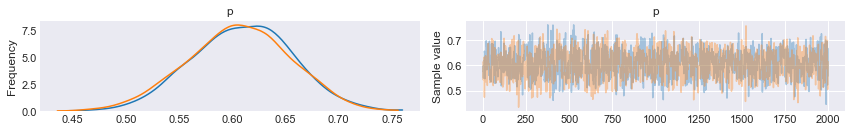

In [50]:
pm.traceplot(trace, varnames=['p'])
pass

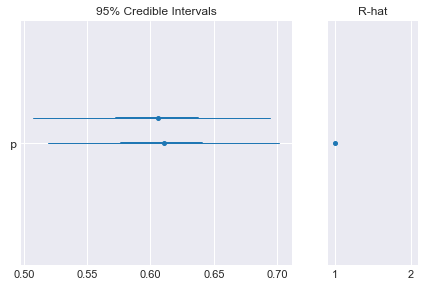

In [53]:
pm.forestplot(trace)
pass

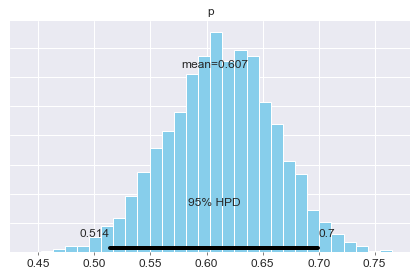

In [54]:
pm.plot_posterior(trace)
pass

#### Prior predictive samples

In [55]:
with coin_context:
    ps = pm.sample_prior_predictive(samples=1000)

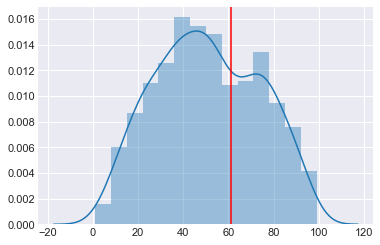

In [56]:
sns.distplot(ps['y'])
plt.axvline(heads, c='red')
pass

#### Posterior predictive samples

In [57]:
with coin_context:
    ps = pm.sample_posterior_predictive(trace, samples=1000)

100%|██████████| 1000/1000 [00:00<00:00, 1386.64it/s]


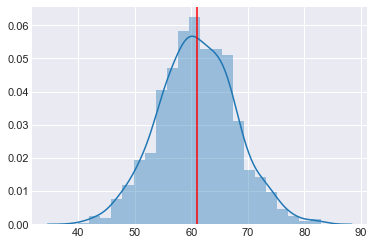

In [58]:
sns.distplot(ps['y'])
plt.axvline(heads, c='red')
pass

## Saving traces

In [59]:
pm.save_trace(trace, 'my_trace', overwrite=True)

'my_trace'

You need to re-initialize the model when reloading.

In [60]:
with pm.Model() as my_trace:
    p = pm.Beta('p', alpha=2, beta=2)
    y = pm.Binomial('y', n=n, p=p, observed=heads)
    tr = pm.load_trace('my_trace')

In [61]:
pm.summary(tr)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
p,0.607161,0.047751,0.001174,0.513838,0.699736,1639.080477,1.001184


It is probably a good practice to make model reuse convenient

In [62]:
def build_model():
    with pm.Model() as m:
        p = pm.Beta('p', alpha=2, beta=2)
        y = pm.Binomial('y', n=n, p=p, observed=heads)
    return m

In [63]:
m = build_model()

In [64]:
with m:
    tr1 = pm.load_trace('my_trace')

In [65]:
pm.summary(tr1)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
p,0.607161,0.047751,0.001174,0.513838,0.699736,1639.080477,1.001184


## Sampling from prior

Just omit the `observed=` argument.

In [66]:
with pm.Model() as prior_context:
    sigma = pm.Gamma('sigma', alpha=2.0, beta=1.0)
    mu = pm.Normal('mu', mu=0, sd=sigma)
    trace = pm.sample(niter, step=pm.Metropolis())

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [mu]
>Metropolis: [sigma]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:01<00:00, 2753.43draws/s]
The number of effective samples is smaller than 10% for some parameters.


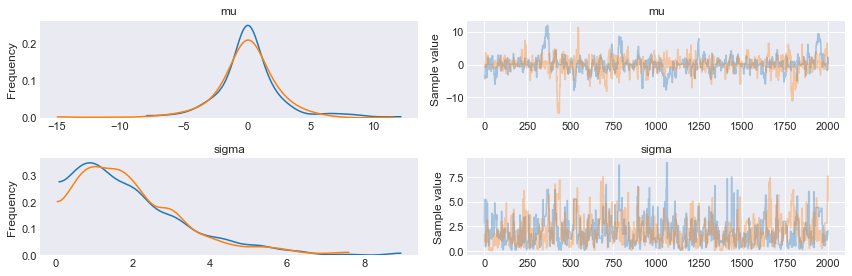

In [68]:
pm.traceplot(trace, varnames=['mu', 'sigma'])
pass

## Sampling from posterior

In [69]:
niter = 2000
with pm.Model() as normal_context:
    mu = pm.Normal('mu', mu=0, sd=100)
    sd = pm.HalfCauchy('sd', beta=2)
    y = pm.Normal('y', mu=mu, sd=sd, observed=xs)
    trace = pm.sample(niter)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, mu]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:03<00:00, 1307.56draws/s]


#### Find Highest Posterior Density (Credible intervals)

In [70]:
hpd = pm.hpd(trace['mu'], alpha=0.05)
hpd

array([0.44162207, 0.55971851])

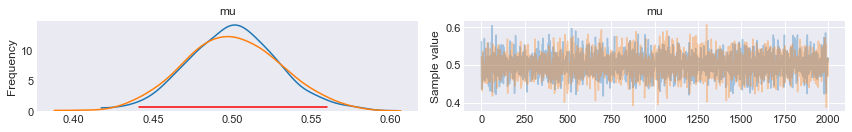

In [72]:
ax = pm.traceplot(trace, varnames=['mu'],)

ymin, ymax = ax[0,0].get_ylim()
y = ymin + 0.05*(ymax-ymin)
ax[0, 0].plot(hpd, [y,y], c='red')
pass

## Evaluating goodness-of-fit

DIC, WAIC and BPIC are approximations to the out-of-sample error and can be used for model comparison. Likelihood is dependent on model complexity and should not be used for model comparisons.

In [73]:
post_mean = pm.summary(trace, varnames=trace.varnames)['mean']
post_mean

mu          0.500164
sd_log__   -1.218045
sd          0.296556
Name: mean, dtype: float64

#### Likelihood

In [74]:
normal_context.logp(post_mean)

array(-26.57766616)

#### Cross-validation

In [75]:
with normal_context:
    print(pm.loo(trace))

/Users/cliburn/anaconda3/lib/python3.6/site-packages/pymc3/stats.py:167: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return np.stack(logp)


LOO_r(LOO=40.743463301462626, LOO_se=8.891566223871754, p_LOO=1.3902023282742455, shape_warn=0)


#### WAIC

In [76]:
with normal_context:
    print(pm.waic(trace))

WAIC_r(WAIC=40.74205569255692, WAIC_se=8.891356706673374, p_WAIC=1.3894985238213904, var_warn=0)


## Using a custom likelihood

In [77]:
def logp(x, μ=0, σ=1):
    """Normal distribtuion."""
    return -0.5*np.log(2*np.pi) - np.log(σ) - (x-μ)**2/(2*σ**2)

In [78]:
with pm.Model() as prior_context:
    mu = pm.Normal('mu', mu=0, sd=100)
    sd = pm.HalfCauchy('sd', beta=2)
    y = pm.DensityDist('y', logp, observed=dict(x=xs, μ=mu, σ=sd))
    custom_trace = pm.sample(niter)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, mu]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:03<00:00, 1316.85draws/s]


In [79]:
pm.trace_to_dataframe(custom_trace).mean()

mu    0.499692
sd    0.296759
dtype: float64

### Variational methods available

To use a variational method, use `pm.fit` instead of `pm.sample`. We'll see examples of usage in another notebook.

In [80]:
print('\n'.join(m for m in dir(pm.variational) if m[0].isupper()))

ADVI
ASVGD
Approximation
Empirical
FullRank
FullRankADVI
Group
ImplicitGradient
Inference
KLqp
MeanField
NFVI
NormalizingFlow
SVGD
Stein
